# Imports

In [ ]:
def preprocess_url(url):
    text = to_txt(url)
    row_vec = vectorizer.transform([text])
    row_df = pd.DataFrame(row_vec.A, columns=VOC)
    row_df['dots'] = [num_dots(url)]
    row_df['bar'] = [num_bar(url)]
    row_df['len'] = [len(text)]
    row_df['digits'] = [num_digits(text)]
    return clf.predict(row_df.values)[0] 

In [ ]:
!pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("harisudhan411/phishing-and-legitimate-urls")

print("Path to dataset files:", path)

100%|██████████| 12.5M/12.5M [00:01<00:00, 12.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/harisudhan411/phishing-and-legitimate-urls/versions/1


In [ ]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import plot_tree

import matplotlib.pyplot as plt
import re

In [ ]:
df = pd.read_csv('/root/.cache/kagglehub/datasets/harisudhan411/phishing-and-legitimate-urls/versions/1/new_data_urls.csv')
df.head()

,url,status
0,0000111servicehelpdesk.godaddysites.com,0
1,000011accesswebform.godaddysites.com,0
2,00003.online,0
3,0009servicedeskowa.godaddysites.com,0
4,000n38p.wcomhost.com,0


In [ ]:
print(len(df[df['status']==0]), len(df[df['status']==1]))
df_maj, df_min = df[df['status']==1], df[df['status']==0]
df_maj_sampled = df_maj.sample(len(df_min), random_state=42)
df_balanced = pd.concat([df_maj_sampled, df_min])
print(len(df_balanced[df_balanced['status']==0]), len(df_balanced[df_balanced['status']==1]))
df_balanced.reset_index(inplace=True, drop=True)
df_balanced

394982 427028
394982 394982


,url,status
0,barrybartlett.net/,1
1,archive.org/stream/cihm_03838/cihm_03838_djvu.txt,1
2,strategyfirst.net/,1
3,www.macminute.com/headlines.xml,1
4,vrealities.com/sensio.html,1
...,...,...
789959,zzufg.com,0
789960,zzu.li,0
789961,zzz.co.uk,0
789962,zzzoolight.co.za,0


# Utils

In [ ]:
def tok(string) -> str:
    return string.replace('/', '.').split('.')

def to_txt(text) -> str:
    return text.replace('.', ' ').replace('/', ' ')

In [ ]:
def top_terms(df, n) -> list[str]:
    term = {}
    for url, status in df.values:
        for word in tok(url):
            if word != '':
                if word not in term.keys():
                    term[word] = 0

                term[word]+=1

    return [t[0] for t in sorted(term.items(), key=lambda x:x[1], reverse=True)[:n]]

In [ ]:
def num_digits(text) -> int:
    return len(re.findall('\d', text))

def num_dots(text) -> int:
    return len(re.findall('\.', text))

def num_bar(text) -> int:
    return len(re.findall('/', text))

# Vocabulary

In [ ]:
VOC = top_terms(df_balanced, n=10)
VOC

['com', 'https:', 'www', 'html', 'http:', 'org', 'net', 'cn', 'php', 'index']

In [ ]:
CORPUS = [to_txt(url) for url in df_balanced.url]
CORPUS[101]

'answers com topic leveille'

In [ ]:
vectorizer = CountVectorizer(binary=True, vocabulary=VOC)
docTermMatrix = vectorizer.fit_transform(CORPUS)

matrix = pd.DataFrame(docTermMatrix.A, columns=VOC)
matrix['dots'] = [num_dots(text) for text in df_balanced.url]
matrix['bar'] = [num_bar(text) for text in df_balanced.url]
matrix['len'] = [len(text) for text in CORPUS]
matrix['digits'] = [num_digits(text) for text in CORPUS]
matrix

,com,https:,www,html,http:,org,net,cn,php,index,dots,bar,len,digits
0,0,0,0,0,0,0,1,0,0,0,1,1,18,0
1,0,0,0,0,0,1,0,0,0,0,2,3,49,10
2,0,0,0,0,0,0,1,0,0,0,1,1,18,0
3,1,0,1,0,0,0,0,0,0,0,3,1,31,0
4,1,0,0,1,0,0,0,0,0,0,2,1,26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789959,1,0,0,0,0,0,0,0,0,0,1,0,9,0
789960,0,0,0,0,0,0,0,0,0,0,1,0,6,0
789961,0,0,0,0,0,0,0,0,0,0,2,0,9,0
789962,0,0,0,0,0,0,0,0,0,0,2,0,16,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(matrix.values, df_balanced['status'].values, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8824378295240929

In [ ]:
import pickle

# Save the model to a file
filename = 'decision_tree_model.pkl'
pickle.dump(clf, open(filename, 'wb'))

# Download the file
from google.colab import files
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
confusion = confusion_matrix(y_test, y_pred)
confusion

array([[69217,  9787],
       [ 8793, 70196]])

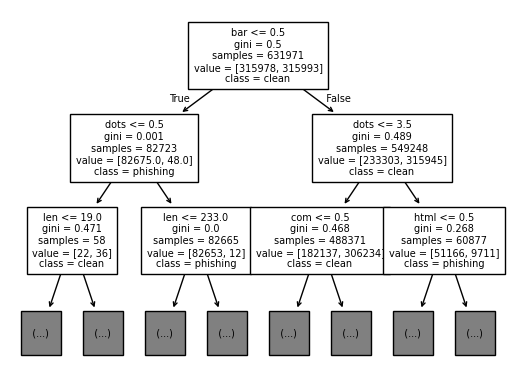

<Figure size 3000x3000 with 0 Axes>

In [ ]:
plot_tree(clf, max_depth=2, feature_names=matrix.columns, class_names=['phishing', 'clean'],
          fontsize=7)
plt.figure(figsize=(30, 30))
plt.show()